# Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, PReLU, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from util import *
from functools import partial
from itertools import combinations
from tqdm import tqdm
import glob
import tensorflow.keras.backend as K
import tensorflow as tf

# Datasets

In [2]:
box_labels = pd.read_csv('label_train.txt', header=None, delimiter=' ', 
                     names=['k', 'i', 'j', 'h', 'w'])

train_images = glob.glob('train\*')
df_images = pd.DataFrame(train_images, columns=['path'])
df_images['w'] = df_images.path.apply(lambda x: Image.open(x).size[0])
df_images['h'] = df_images.path.apply(lambda x: Image.open(x).size[1])
df_images['k'] = [x for x in range(1, 1001)]
df_images

,path,w,h,k
0,train\0001.jpg,450,431,1
1,train\0002.jpg,449,305,2
2,train\0003.jpg,370,450,3
3,train\0004.jpg,409,450,4
4,train\0005.jpg,450,311,5
...,...,...,...,...
995,train\0996.jpg,326,450,996
996,train\0997.jpg,363,449,997
997,train\0998.jpg,294,450,998
998,train\0999.jpg,354,410,999


# Box Size distribution

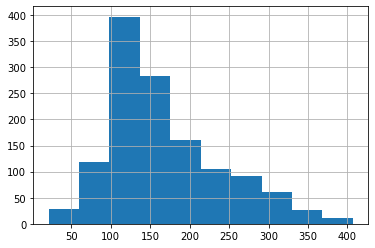

In [4]:
box_labels.h.hist()

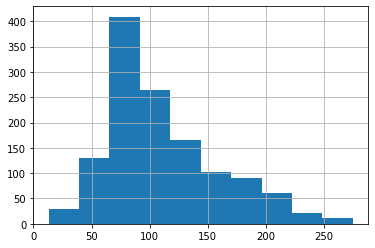

In [5]:
box_labels.w.hist()

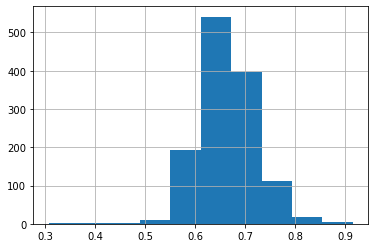

In [6]:
(box_labels.w / box_labels.h).hist()

# Find best window size and stride

In [7]:
f_part = partial(get_params_perf, imgs=df_images, labels=box_labels)

In [ ]:
%%time
if __name__ == '__main__':
    strides = [30,35,40]
    sizes = [[(100,85),(200,100),(250,212)]]

#     for x in range(75, 400, 25):
#         sizes.append([(x, int(x*0.50))])
#         sizes.append([(x, int(x*0.65))])
#         sizes.append([(x, int(x*0.85))])
#         sizes.append([(x, x)])
    
    paramlist = list(itertools.product(strides, sizes))

    print(paramlist, len(paramlist))

    ret = []
    
    with Pool() as p:
        for m in tqdm(p.imap_unordered(f_part, paramlist)):
            ret.append(m)

In [ ]:
vp, box_list, stats = zip(*ret)

In [ ]:
stats = pd.DataFrame(stats)
stats['mean/num_im'] = stats['mean']*100 / stats['num_im']
stats.sort_values('acc', ascending=False)

In [ ]:
test = vp[33] + vp[40] + vp[13]
acc = sum(test > 0)/len(test)
n_im = sum([stats.iloc[i].num_im for i in [33, 40, 13]])
print(acc, n_im)

In [ ]:
# Use combinations to find best window size set
acc2 = []

for v1, v2, v3 in combinations(range(0, len(vp)), r=3):
    temp = vp[v1] + vp[v2] + vp[v3]
    if sum(temp>0)/len(temp) > 0.70:
        acc2.append(((v1, v2, v3), sum(temp>0)/len(temp)))
        
df = pd.DataFrame(acc2)
df['n_im'] = df[0].apply(lambda x: sum([stats.iloc[x[i]].num_im for i in range(0,3)]))

# Dataset Creation

In [8]:
part_create_img_dataset = partial(create_img_dataset,stride=35, window_size=[(100,85),(200,100),(250,212)] , 
                                  box_labels=box_labels, folder_size=('val',32))

if __name__ == '__main__':
    
    train_images = glob.glob('train\*')
    df_images = pd.DataFrame(train_images, columns=['path'])
    df_images['w'] = df_images.path.apply(lambda x: Image.open(x).size[0])
    df_images['h'] = df_images.path.apply(lambda x: Image.open(x).size[1])
    df_images['k'] = [x for x in range(1, 1001)]
    df_images = df_images
    
    ret = []
    
    with Pool() as p:
        for m in tqdm(p.imap_unordered(part_create_img_dataset, df_images.iloc[80:100].iterrows())):
            ret.append(m)

20it [00:04,  5.00it/s]


# CNN

## Global Variables

In [5]:
batch_size = 512
epochs = 40
size = 32
REPRESENTATION_OF_1_IN_LOSS = 0.5
nb1 = len(glob.glob('train32x32/train/1/*'))
nb0 = len(glob.glob('train32x32/train/0/*'))
learning_rate = 0.05
lr_decay = 1e-6
lr_drop = 20
input_shape = (size, size, 3)
weight_decay = 0.0005

steps_per_epochs = (len(glob.glob('train32x32/train/1/*'))+
                    len(glob.glob('train32x32/train/0/*')))/batch_size

validation_steps = (len(glob.glob('train32x32/val/1/*'))+
                    len(glob.glob('train32x32/val/0/*')))/batch_size

## Util functions

In [4]:
# Determine the weight to apply to classes for imbalanced dataset
def class_weight(nb_1, nb_0, representation_of_1_in_loss=REPRESENTATION_OF_1_IN_LOSS):
    weight_0 = (1 - representation_of_1_in_loss) * (nb_0 + nb_1) / nb_0
    weight_1 = representation_of_1_in_loss * (nb_0 + nb_1) / nb_1
    return weight_0, weight_1

# Weighted binary cross entropy
def wbce( y_true, y_pred, sample_weight=None, weight1=1, weight0=1 ):
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0 )
    return K.mean( logloss, axis=(0,1))

# Compute the best f1 score, precision, recall, prediction threshold
def f1(y_true, y_pred):
    df = pd.DataFrame(y_true, columns=['y_true'])
    df['y_pred'] = y_pred
    cleaner = df.duplicated('y_pred', keep='last')
    df = df.sort_values('y_pred', ascending=False)
    df['vp'] = df.y_true.cumsum()
    df['fp'] = (df.y_true == 0).cumsum()
    df['fn'] = sum(df.y_true) - df['vp']
    df['prec'] = df.vp / (df.vp + df.fp)
    df['rec'] = df.vp / (df.vp + df.fn)
    df = df.loc[~cleaner]
    df['f1'] = 2* (df.prec * df.rec) / (df.prec + df.rec)
    best = df['f1'].idxmax()
    return df.loc[best]

# Compute the best f2 score, precision, recall, prediction threshold
def f2(y_true, y_pred):
    df = pd.DataFrame(y_true, columns=['y_true'])
    df['y_pred'] = y_pred
    cleaner = df.duplicated('y_pred', keep='last')
    df = df.sort_values('y_pred', ascending=False)
    df['vp'] = df.y_true.cumsum()
    df['fp'] = (df.y_true == 0).cumsum()
    df['fn'] = sum(df.y_true) - df['vp']
    df['prec'] = df.vp / (df.vp + df.fp)
    df['rec'] = df.vp / (df.vp + df.fn)
    df = df.loc[~cleaner]
    df['f2'] = 5* (df.prec * df.rec) / (4*df.prec + df.rec)
    best = df['f2'].idxmax()
    return df.loc[best]

## Callback

In [12]:
# Keras Callback computing f1, precision, recall on epoch end
class f1_class(Callback):
    def __init__(self, val_generator=None):
        super(Callback, self).__init__()                
        self.validation_generator = val_generator

            
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.f2s = []
        self.ps = []
        self.re = []
        self.y_true = np.array(self.validation_generator.labels)
        
        
    def get_f1_thresh(self, y_true, y_pred):
        df = pd.DataFrame(y_true, columns=['y_true'])
        df['y_pred'] = y_pred
        cleaner = df.duplicated('y_pred', keep='last')
        df = df.sort_values('y_pred', ascending=False)
        df['vp'] = df.y_true.cumsum()
        df['fp'] = (df.y_true == 0).cumsum()
        df['fn'] = sum(df.y_true) - df['vp']
        df['prec'] = df.vp / (df.vp + df.fp)
        df['rec'] = df.vp / (df.vp + df.fn)
        df = df.loc[~cleaner]
        df['f1'] = 2* (df.prec * df.rec) / (df.prec + df.rec)
        df['f2'] = 5* (df.prec * df.rec) / (4*df.prec + df.rec)
        bestf1 = df['f1'].idxmax()
        bestf2 = df['f2'].idxmax()
        return df.loc[bestf1], df.loc[bestf2].f2
        
        
    def on_epoch_end(self, epoch, logs=None):   
        if epoch>=10:
            y_pred = self.model.predict_generator(self.validation_generator).flatten()


            best, f2 = self.get_f1_thresh(self.y_true, y_pred)

            score = best.f1
            p = best.prec
            r = best.rec

            self.f1s.append(score)
            self.ps.append(p)
            self.re.append(r)
            self.f2s.append(f2)
            
            logs['f1'] = score

            print("interval evaluation - epoch: {:d} - f1: {:.6f}, f2: {:.6f}, precision: {:.6f}, recall: {:.6f}".format(epoch, score, f2, p, r))
        else:
            logs['f1'] = 0
        
        
# def lr_scheduler(epoch):
#     return learning_rate * (0.5 ** (epoch // lr_drop))


# reduce_lr = LearningRateScheduler(lr_scheduler)

mc = ModelCheckpoint('model_weights/final04.{epoch:02d}-{loss:.2f}.hdf5', save_weights_only=True)
es = EarlyStopping(monitor='f1', patience=20, mode='max', restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='loss', patience=6, factor=0.5, verbose=1)

## Data generators

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'train32x32/train',
    target_size=(size,size),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    'train32x32/val',
    target_size=(size,size),
    batch_size=batch_size,
    class_mode='binary')


# Defined 2 generators without suffle for testing purpose
train_gen_no_shuffle = test_datagen.flow_from_directory(
    'train32x32/train',
    target_size=(size,size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

val_gen_no_shuffle = test_datagen.flow_from_directory(
    'train32x32/val',
    target_size=(size,size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 151331 images belonging to 2 classes.
Found 151331 images belonging to 2 classes.


## Model

In [7]:


model = get_model()

## Training

In [8]:
# Partials functions to pass to the model
w0, w1 = class_weight(nb1, nb0)
wb_part = partial(wbce, weight1=w1, weight0=w0)
# f1_cb = f1_class(val_gen_no_shuffle)

model.compile(loss=wb_part,
              optimizer=Adam(),
              metrics=['accuracy'])

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epochs,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[rl, mc],
    verbose=2)

Epoch 1/40
296/295 - 157s - loss: 0.2327 - accuracy: 0.8941
Epoch 2/40
296/295 - 155s - loss: 0.1836 - accuracy: 0.9153
Epoch 3/40
296/295 - 154s - loss: 0.1607 - accuracy: 0.9246
Epoch 4/40
296/295 - 155s - loss: 0.1468 - accuracy: 0.9330
Epoch 5/40
296/295 - 154s - loss: 0.1326 - accuracy: 0.9391
Epoch 6/40
296/295 - 154s - loss: 0.1201 - accuracy: 0.9441
Epoch 7/40
296/295 - 154s - loss: 0.1187 - accuracy: 0.9468
Epoch 8/40
296/295 - 154s - loss: 0.1125 - accuracy: 0.9486
Epoch 9/40
296/295 - 154s - loss: 0.1057 - accuracy: 0.9518
Epoch 10/40
296/295 - 153s - loss: 0.1049 - accuracy: 0.9520
Epoch 11/40
296/295 - 153s - loss: 0.1197 - accuracy: 0.9477
Epoch 12/40
296/295 - 153s - loss: 0.1078 - accuracy: 0.9511
Epoch 13/40
296/295 - 153s - loss: 0.1023 - accuracy: 0.9541
Epoch 14/40
296/295 - 153s - loss: 0.0919 - accuracy: 0.9593
Epoch 15/40
296/295 - 153s - loss: 0.0904 - accuracy: 0.9579
Epoch 16/40
296/295 - 153s - loss: 0.0861 - accuracy: 0.9598
Epoch 17/40
296/295 - 153s - loss

In [34]:
# model.save_weights('model_weigths')
# model.save_weights('model_40ep_32x32.h5')

In [21]:
model.load_weights('model_weights/final04.40-0.06.hdf5')

##  perf indicators

In [22]:
y_true = train_gen_no_shuffle.labels
y_pred = model.predict_generator(train_gen_no_shuffle)

### F1 training

In [23]:
f1(y_true, y_pred.flatten())

y_true       1.000000
y_pred       0.980422
vp        5770.000000
fp         813.000000
fn         524.000000
prec         0.876500
rec          0.916746
f1           0.896171
Name: 145719, dtype: float64

In [24]:
f2(y_true, y_pred.flatten())

y_true       1.000000
y_pred       0.934110
vp        6112.000000
fp        1539.000000
fn         182.000000
prec         0.798850
rec          0.971084
f2           0.930941
Name: 149787, dtype: float64

### F1 val

In [13]:
%%time
y_val_true = val_gen_no_shuffle.labels
y_val_pred = model.predict_generator(val_gen_no_shuffle)
f1(y_val_true, y_val_pred.flatten())

Wall time: 20.6 s


y_true       1.000000
y_pred       0.893446
vp        1130.000000
fp         208.000000
fn         103.000000
prec         0.844544
rec          0.916464
f1           0.879035
Name: 29761, dtype: float64

In [14]:
f2(y_val_true, y_val_pred.flatten())

y_true       1.000000
y_pred       0.711501
vp        1172.000000
fp         322.000000
fn          61.000000
prec         0.784471
rec          0.950527
f2           0.911920
Name: 29888, dtype: float64

## Plots

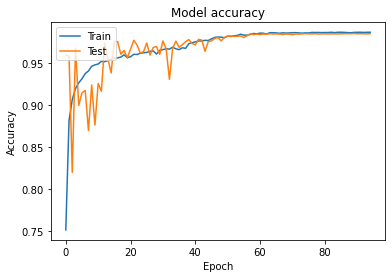

In [66]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

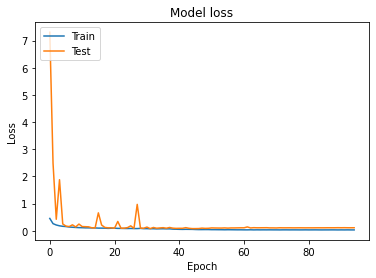

In [67]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

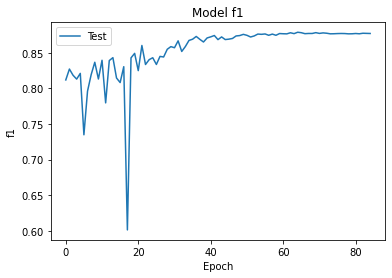

In [68]:
plt.plot(f1_cb.f1s)
plt.title('Model f1')
plt.ylabel('f1')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()

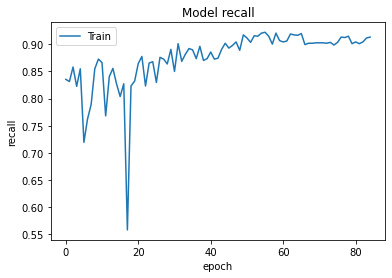

In [69]:
# Plot training & validation loss values
plt.plot(f1_cb.re)
plt.title('Model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

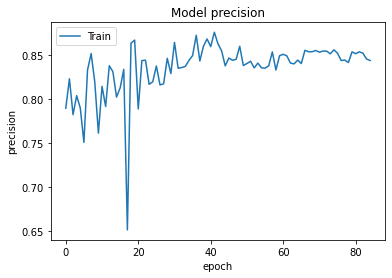

In [70]:
# Plot training & validation loss values
plt.plot(f1_cb.ps )
plt.title('Model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()